The following code is used to QC the training and testing of BuDDi (diva.py). Includes plots of the different lossses and cell types by experiment.

Specifically this notebok includes the plots for: 300 epochs with 0.0005 learnign rate (main experiment), 100 epochs with 0.01 learning rate, 500 epochs with 0.0005 learning rate.

In [1]:
# import the code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from cortex_sc_preprocessing import sc_preprocess

# general imports
import warnings
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from scipy.stats import spearmanr, pearsonr
from collections import Counter

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

#module import to reload sc_preprocess
from importlib import reload 
sc_preprocess = reload(sc_preprocess)

Set up experiment parameters

In [2]:
# number of pseudobulks PER patient
n_train = 1000

### create the domains label 

# first for 10x data
Label_full_10x = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 2), np.full(n_train, 3),
                            np.full(n_train, 4), np.full(n_train, 5),
                            np.full(n_train, 6), np.full(n_train, 7),
                            np.full(n_train, 8), np.full(n_train, 9)], axis=0)
label_full_10x = to_categorical(Label_full_10x)

Label_perturb = np.concatenate([np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 0), np.full(n_train, 0),
                            np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 1), np.full(n_train, 1),
                            np.full(n_train, 0), np.full(n_train, 0)], axis=0)
label_perturb = to_categorical(Label_perturb)


label_full_10x

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Load Data

In [3]:
work_dir= os.getcwd() 
res_path= f"{work_dir}/../../results/single_cell_data/diva_cortex"
data_path=f"{work_dir}/../../data/single_cell_data/augmented_cortex_data/"
bp_res_path = f"{work_dir}/../../results/single_cell_data/bp_cortex/"
cs_res_path = f"{work_dir}/../../results/single_cell_data/cibersort_cortex/"

def read_gene_file(res_path, exp_id):
    gene_file = os.path.join(res_path, f"train-{exp_id}-DIVA_features.pkl")
    gene_path = Path(gene_file)
    gene_df_train = pickle.load( open( gene_path, "rb" ) )
    return gene_df_train

exp_id = "cortex6k"
cortex6k_X, cortex6k_Y, cortex6k_gene_df = sc_preprocess.read_all_diva_files(data_path, range(10), exp_id)
cortex6k_X.columns = cortex6k_gene_df

This is the first experiment 100 epochs and 0.01 LR unlab_id = "cortex6k".

In [4]:
lab_id = "cortex6k"
unlab_id = "cortex6k_200epoch_decLR"
cortex6k_enc = tf.keras.models.load_model(f"{res_path}/{lab_id}_{unlab_id}_encoder")
cortex6k_train = read_gene_file(res_path, f"{lab_id}-{unlab_id}")

2023-01-24 11:01:30.718968: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Make TSNE of raw and trainign data

In [5]:
def make_tsne_fig(X_df, color_vec, ax, title):
    ## plot samples
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsne = TSNE(n_components=2, verbose=0, perplexity=40, init="pca", learning_rate='auto')
        tsne_results = tsne.fit_transform(scale(np.log2(X_df.astype(float)+1.0), axis=1))

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    plot_df['class'] = color_vec

    n_colors = len(np.unique(color_vec))
    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="class",
        palette=sns.color_palette("hls", n_colors),
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g

(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)


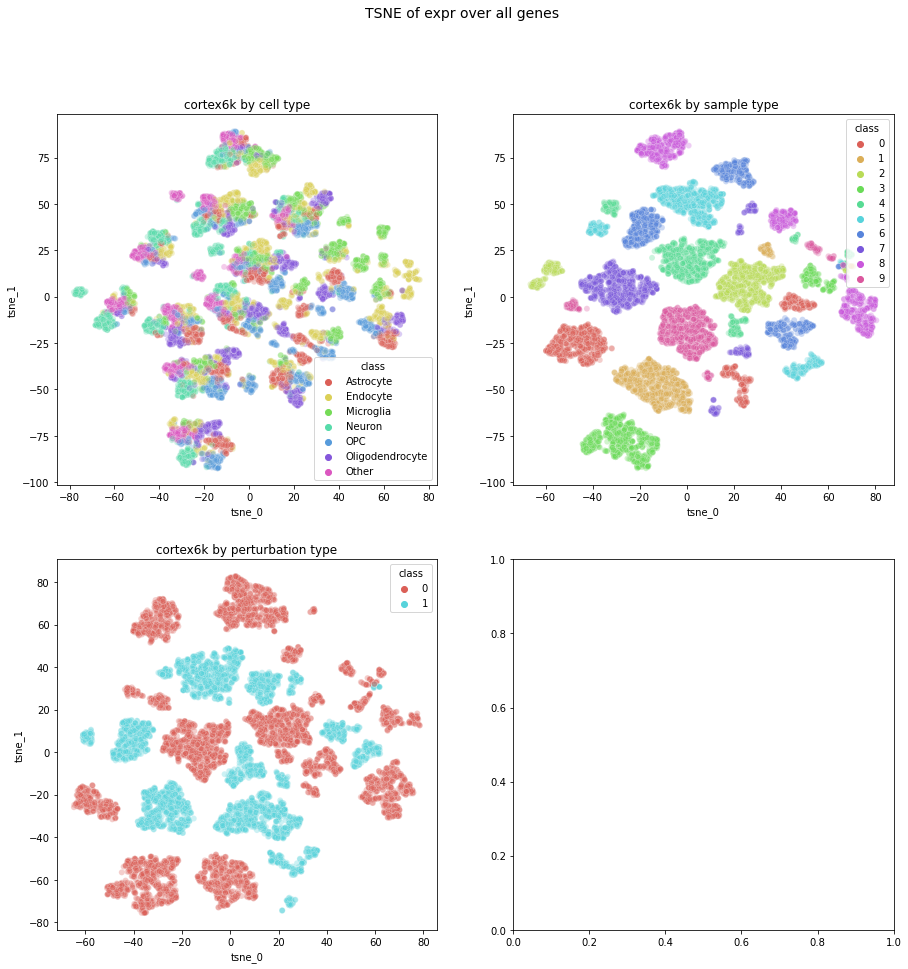

In [6]:

# plot over all genes
fig, axs = plt.subplots(2, 2, figsize=(15,15))
tmp_Y = cortex6k_Y
tmp_Y = tmp_Y.to_numpy()

tmp_Y = cortex6k_Y.columns[np.argmax(tmp_Y, axis=1)]
make_tsne_fig(cortex6k_X, tmp_Y, ax=axs[0,0], title="cortex6k by cell type")
make_tsne_fig(cortex6k_X, Label_full_10x, ax=axs[0,1], title="cortex6k by sample type")
make_tsne_fig(cortex6k_X, Label_perturb, ax=axs[1,0], title="cortex6k by perturbation type")

fig.suptitle("TSNE of expr over all genes", fontsize=14)

fig.show()

Plot Loss Curves:

In [9]:
def read_loss_file(res_path, exp_id, unlab_id):
    loss_file = os.path.join(res_path, f"train-{exp_id}-{unlab_id}-DIVA_loss.pkl")
    loss_path = Path(loss_file)
    loss_df = pickle.load( open( loss_path, "rb" ) )
    return loss_df

def make_loss_fig(loss_df, ax, title, loss_to_plot):
    ## plot loss
    g = sns.lineplot(
        x="batch", y=loss_to_plot,
        data=loss_df,
        hue="type",
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g

Log prop loss in order to see the actual changes.

In [10]:
#Logarizing loss columns of dataframe to ease visualization
def logdf(df, variable):
    df[variable] = df[variable].astype('float')
    df[variable] = np.log2(df[variable])
    return df[variable]

Total Loss:

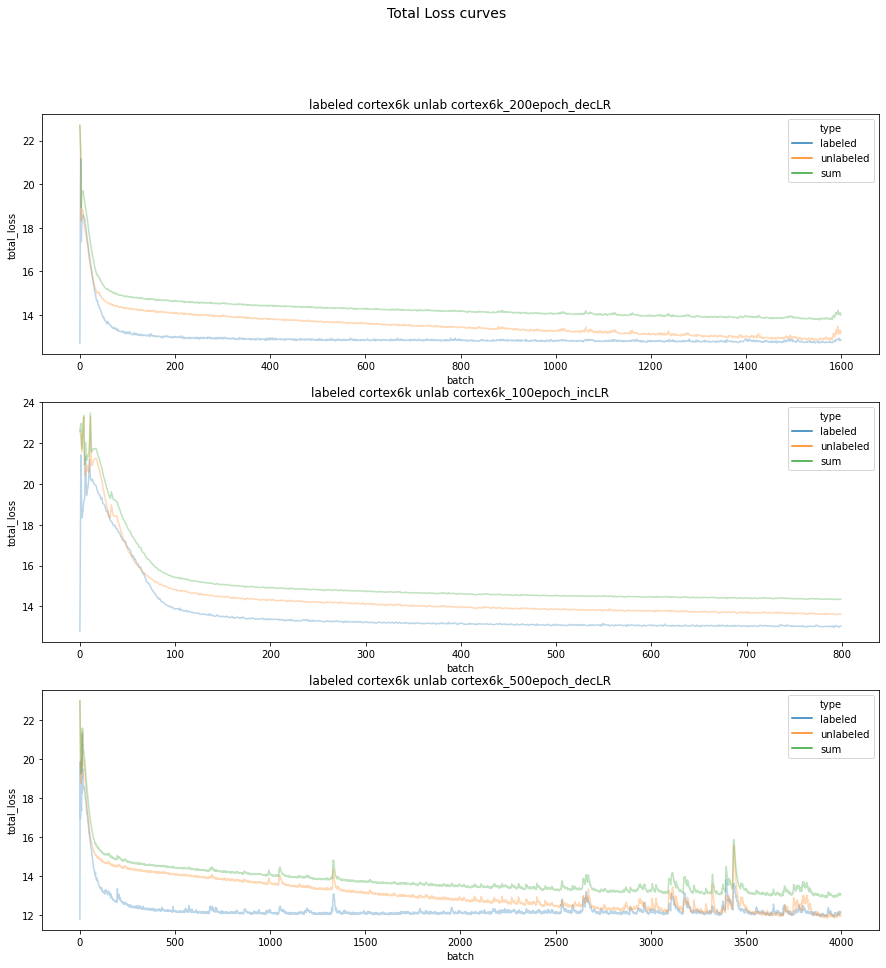

In [11]:
loss_to_plot = "total_loss"
fig, axs = plt.subplots(3, figsize=(15,15))

exp_id="cortex6k"
unlab_exp_id= "cortex6k_200epoch_decLR"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
loss_df1['total_loss'] = logdf(loss_df1, 'total_loss')
make_loss_fig(loss_df1, ax=axs[0], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)


exp_id="cortex6k"
unlab_exp_id= "cortex6k_100epoch_incLR"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
loss_df1['total_loss'] = logdf(loss_df1, 'total_loss')
make_loss_fig(loss_df1, ax=axs[1], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)


exp_id="cortex6k"
unlab_exp_id="cortex6k_500epoch_decLR"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
loss_df1['total_loss'] = logdf(loss_df1, 'total_loss')
make_loss_fig(loss_df1, ax=axs[2], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)

fig.suptitle("Total Loss curves", fontsize=14)
fig.show()

Reconstruction Loss:

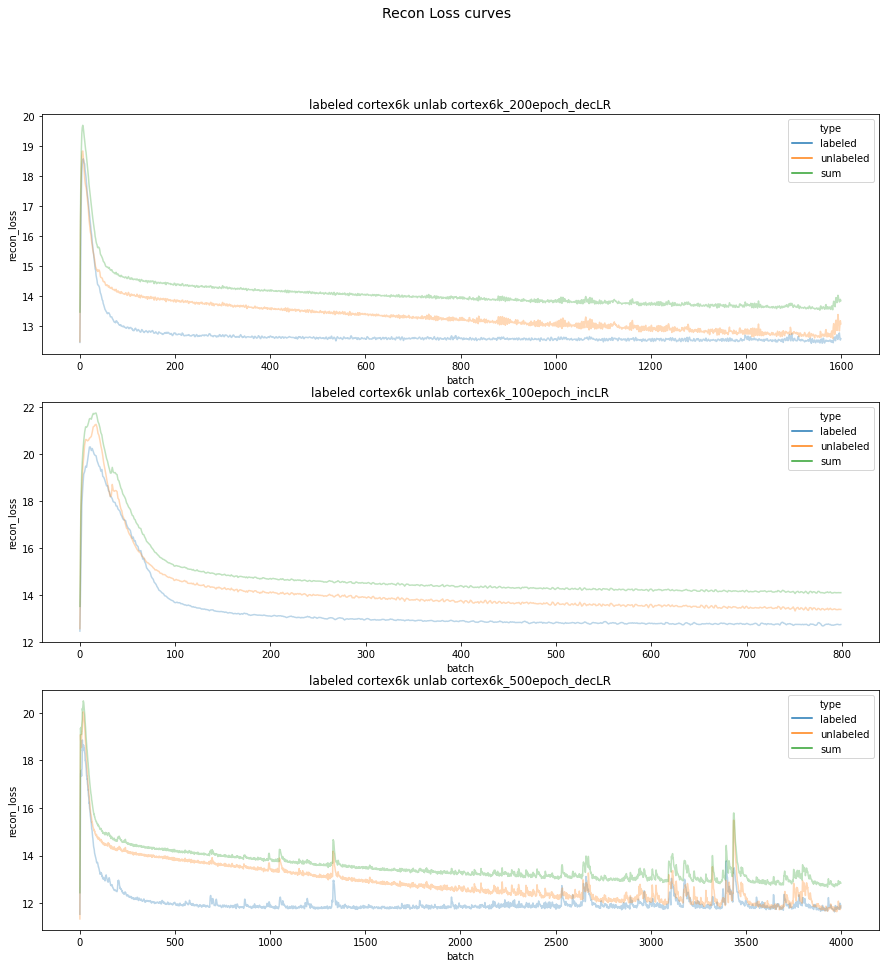

In [12]:
loss_to_plot = "recon_loss"
fig, axs = plt.subplots(3, figsize=(15,15))

exp_id="cortex6k"
unlab_exp_id="cortex6k_200epoch_decLR"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
loss_df1['recon_loss'] = logdf(loss_df1, 'recon_loss')
make_loss_fig(loss_df1, ax=axs[0], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)


exp_id="cortex6k"
unlab_exp_id="cortex6k_100epoch_incLR"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
loss_df1['recon_loss'] = logdf(loss_df1, 'recon_loss')
make_loss_fig(loss_df1, ax=axs[1], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)


exp_id="cortex6k"
unlab_exp_id="cortex6k_500epoch_decLR"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
loss_df1['recon_loss'] = logdf(loss_df1, 'recon_loss')
make_loss_fig(loss_df1, ax=axs[2], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)

fig.suptitle("Recon Loss curves", fontsize=14)
fig.show()


Proportion Loss

In [13]:
type(loss_df1['prop_loss'][7000])

tuple

In [14]:
#prop_loss in tuple form in some cases (X,), need it to be float to log.
def forprop_loss(df, variable):
    for i in range(0,len(df[variable])):
        if type(df[variable][i]) == tuple:
            df[variable][i] = df[variable][i][0]
            df[variable][i] = df[variable][i].astype('float')
    return df[variable]

/tmp/ipykernel_15441/3410411877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variable][i] = df[variable][i][0]
/tmp/ipykernel_15441/3410411877.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[variable][i] = df[variable][i].astype('float')
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_15441/3410411877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

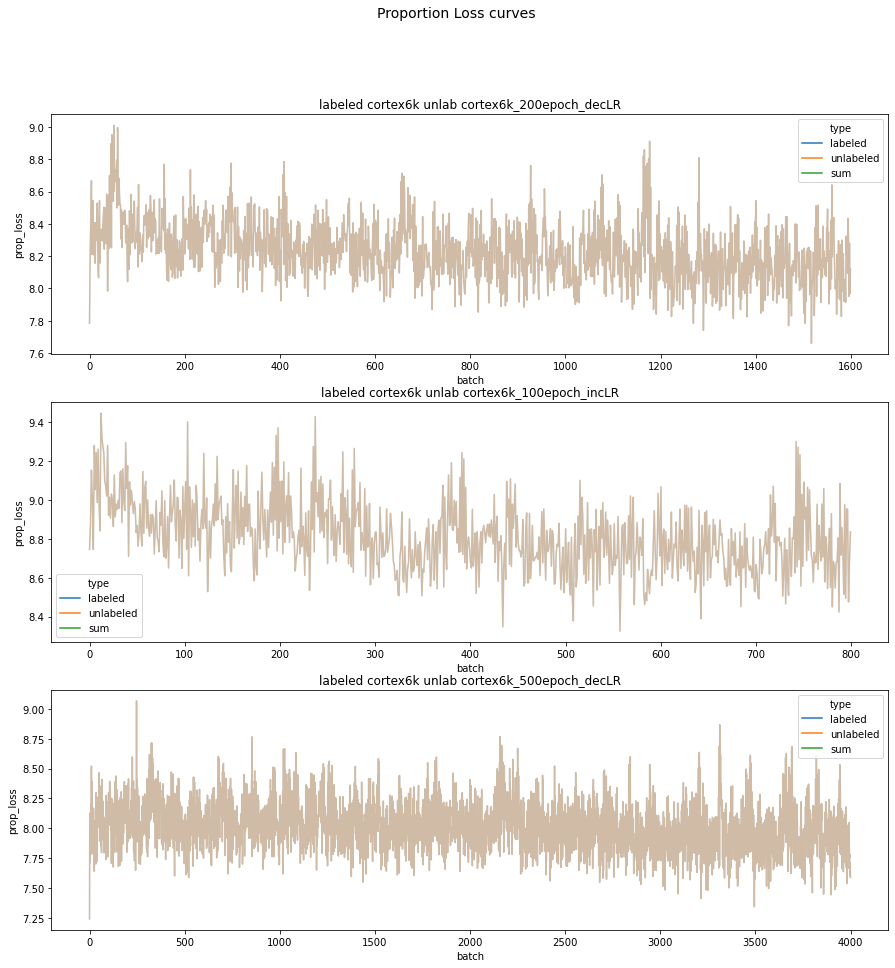

In [15]:
loss_to_plot = "prop_loss"
fig, axs = plt.subplots(3, figsize=(15,15))

exp_id="cortex6k"
unlab_exp_id="cortex6k_200epoch_decLR"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
loss_df1['prop_loss'] = loss_df1['prop_loss'].fillna(0)  
loss_df1['prop_loss'] = forprop_loss(loss_df1,'prop_loss')
loss_df1['prop_loss'] = logdf(loss_df1, 'prop_loss')
make_loss_fig(loss_df1, ax=axs[0], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)


exp_id="cortex6k"
unlab_exp_id="cortex6k_100epoch_incLR"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
loss_df1['prop_loss'] = loss_df1['prop_loss'].fillna(0)  
loss_df1['prop_loss'] = forprop_loss(loss_df1,'prop_loss')
loss_df1['prop_loss'] = logdf(loss_df1, 'prop_loss')
make_loss_fig(loss_df1, ax=axs[1], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)


exp_id="cortex6k"
unlab_exp_id="cortex6k_500epoch_decLR"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
loss_df1['prop_loss'] = loss_df1['prop_loss'].fillna(0)  
loss_df1['prop_loss'] = forprop_loss(loss_df1,'prop_loss')
loss_df1['prop_loss'] = logdf(loss_df1, 'prop_loss')
make_loss_fig(loss_df1, ax=axs[2], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)

fig.suptitle("Proportion Loss curves", fontsize=14)

fig.show()

Sample Prediction Loss

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


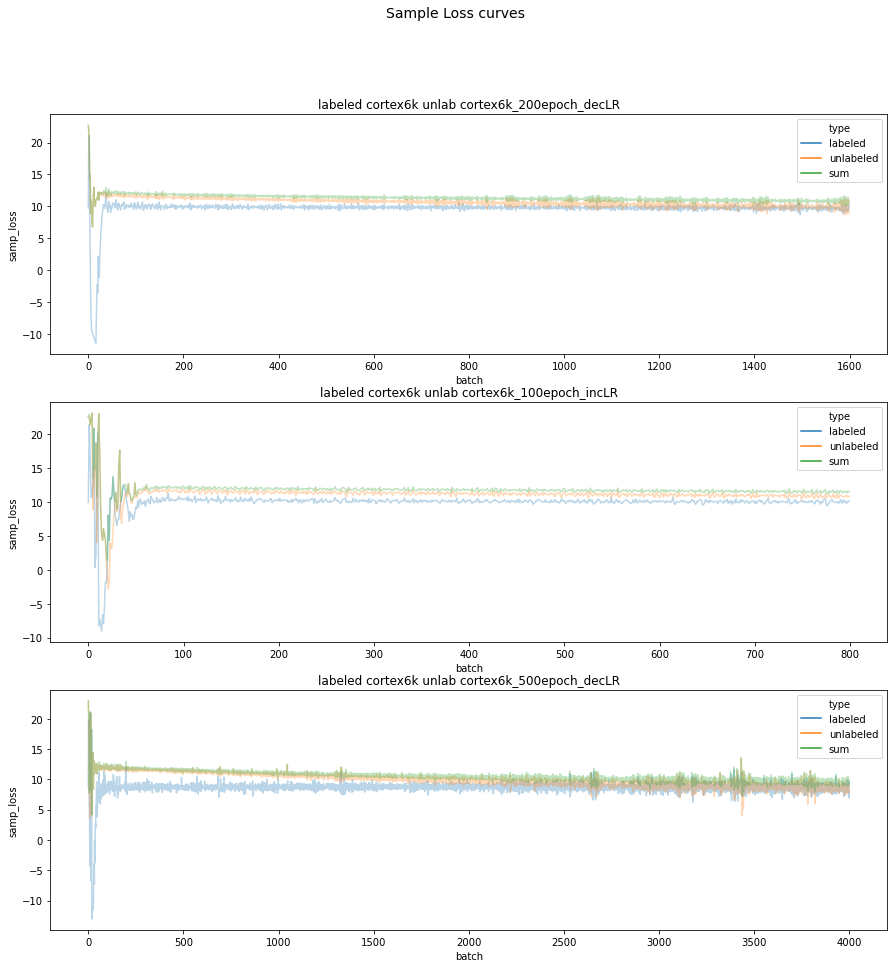

In [16]:
loss_to_plot = "samp_loss"
fig, axs = plt.subplots(3, figsize=(15,15))

exp_id="cortex6k"
unlab_exp_id="cortex6k_200epoch_decLR"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
loss_df1['samp_loss'] = logdf(loss_df1, 'samp_loss')
make_loss_fig(loss_df1, ax=axs[0], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)

exp_id="cortex6k"
unlab_exp_id="cortex6k_100epoch_incLR"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
loss_df1['samp_loss'] = logdf(loss_df1, 'samp_loss')
make_loss_fig(loss_df1, ax=axs[1], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)

exp_id="cortex6k"
unlab_exp_id="cortex6k_500epoch_decLR" 
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
loss_df1['samp_loss'] = logdf(loss_df1, 'samp_loss')
make_loss_fig(loss_df1, ax=axs[2], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)

fig.suptitle("Sample Loss curves", fontsize=14)

fig.show()

Plot Encodings


TSNE on training data

Here we are now interested in training on cortex6k and testing on other settings. So we will first show how well we perform on our training data:

In [17]:
def get_tsne_for_plotting(encodings):
    tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=500)
    tsne_results = tsne.fit_transform(encodings)

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    return plot_df

def plot_tsne(plot_df, color_vec, ax, title):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=0.3, ax= ax
    )

    ax.set_title(title)
    return g

In [18]:
idx_perturb = np.where(np.logical_and(Label_full_10x>5, Label_full_10x<10))[0]

In [19]:
idx_train = np.where(np.logical_and(Label_full_10x!=5, Label_full_10x!=0))[0]

X_temp = cortex6k_X.reindex(columns=cortex6k_train, fill_value=0)
X_temp = X_temp.to_numpy()
X_temp = X_temp[idx_train]
X_temp
Y_temp = cortex6k_Y
Y_temp = cortex6k_Y.columns[np.argmax(Y_temp.to_numpy(), axis=1)]
Y_temp = Y_temp[idx_train]
Counter(Y_temp)

Counter({'Oligodendrocyte': 1136,
         'Neuron': 1144,
         'OPC': 1138,
         'Microglia': 1149,
         'Other': 1100,
         'Astrocyte': 1144,
         'Endocyte': 1189})

Number unique Y: 7


2023-01-24 11:42:54.601443: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.001s...
[t-SNE] Computed neighbors for 8000 samples in 1.642s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 1.271420
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.921196
[t-SNE] KL divergence after 500 iterations: 1.779775
(8000, 2)
(8000, 2)


/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.001s...
[t-SNE] Computed neighbors for 8000 samples in 1.511s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.371430
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.928482
[t-SNE] KL divergence after 500 iterations: 1.584171
(8000, 2)
(8000, 2)


/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.001s...
[t-SNE] Computed neighbors for 8000 samples in 1.378s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 142.779053
[t-SNE] KL divergence after 500 iterations: 4.003222
(8000, 2)
(8000, 2)


/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.033s...
[t-SNE] Computed neighbors for 8000 samples in 3.293s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 7.413819
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.076698
[t-SNE] KL divergence after 500 iterations: 1.281209
(8000, 2)
(8000, 2)


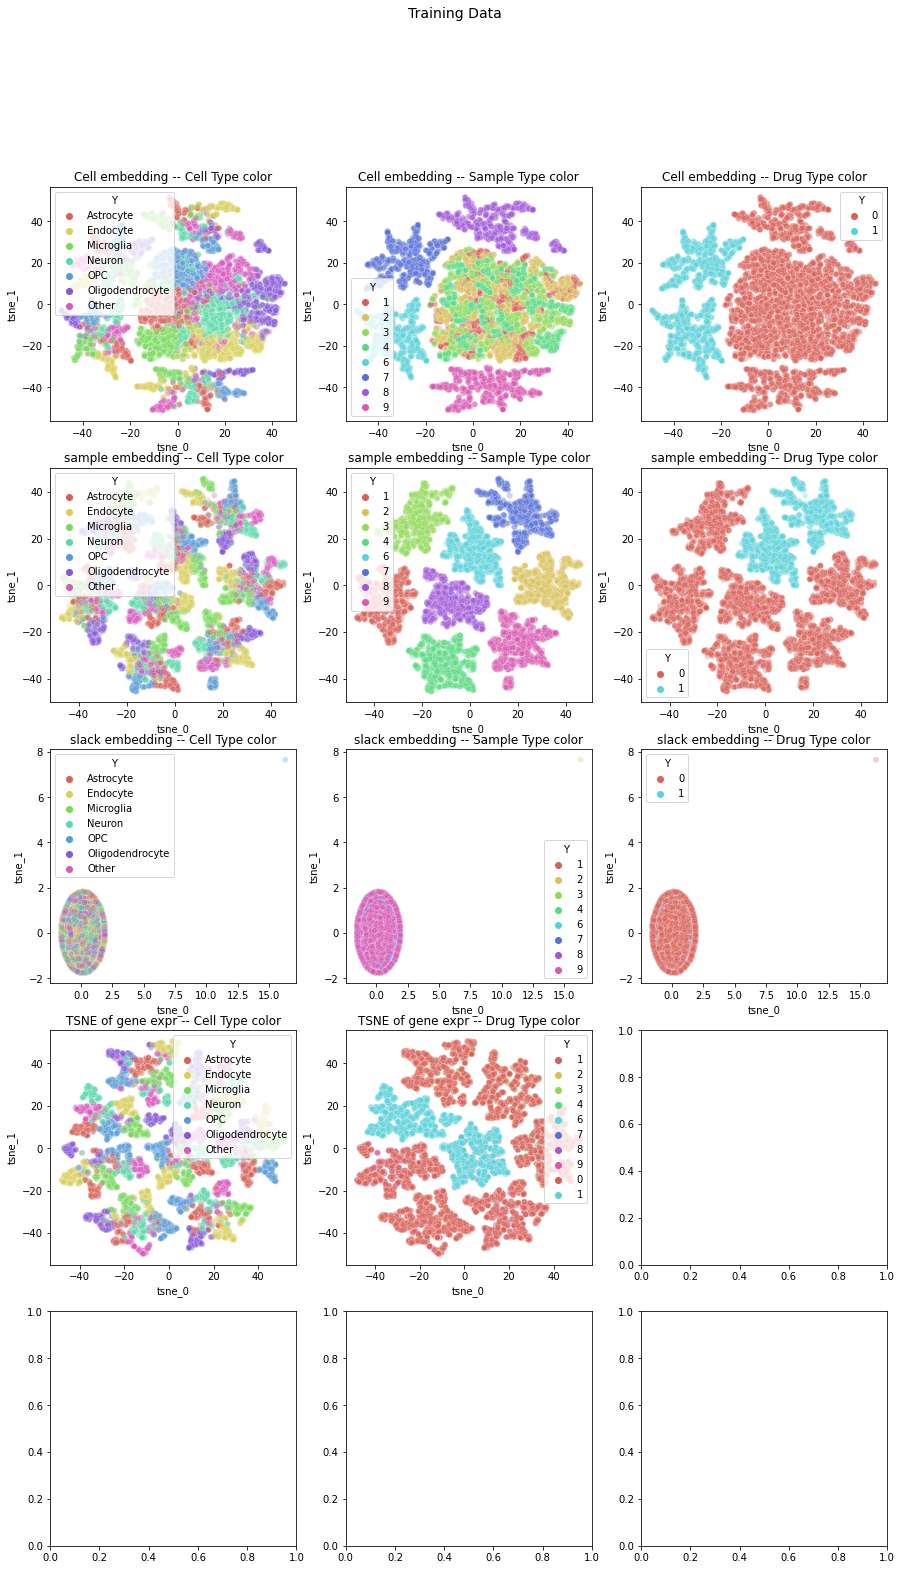

In [20]:
batch_size = 500
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data
idx_train = np.where(np.logical_and(Label_full_10x!=5, Label_full_10x!=0))[0]
idx_unlab = np.where(Label_full_10x >= 5)[0]
idx_perturb = np.where(np.logical_and(Label_full_10x>5, Label_full_10x<8))[0]

X_temp =cortex6k_X.reindex(columns=cortex6k_train, fill_value=0)
X_temp = X_temp.to_numpy()
X_temp = X_temp[idx_train]
X_temp = scale(X_temp, axis=1)

Y_temp = cortex6k_Y
Y_temp = cortex6k_Y.columns[np.argmax(Y_temp.to_numpy(), axis=1)]
Y_temp = Y_temp[idx_train]

label_temp = Label_full_10x[idx_train]
perturb_temp = Label_perturb[idx_train]

print(f"Number unique Y: {len(np.unique(Y_temp))}")

_, mu_slack, _, mu_prop, _, prop_outputs, _, mu_rot, _ = cortex6k_enc.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)

fig, axs = plt.subplots(5, 3, figsize=(15,25))

plot_df = get_tsne_for_plotting(np.asarray(mu_prop))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")
plot_tsne(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="Cell embedding -- Drug Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_rot))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")
plot_tsne(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="sample embedding -- Drug Type color")

#not including since drug perturbations were not run:
# plot_df = get_tsne_for_plotting(np.asarray(mu_drug))
# plot_tsne(plot_df, color_vec=Y_temp, ax=axs[2,0], title="drug embedding -- Cell Type color")
# plot_tsne(plot_df, color_vec=label_temp, ax=axs[2,1], title="drug embedding -- Sample Type color")
# plot_tsne(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="drug embedding -- Drug Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_slack))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[2,0], title="slack embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[2,1], title="slack embedding -- Sample Type color")
plot_tsne(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="slack embedding -- Drug Type color")

plot_df = get_tsne_for_plotting(np.asarray(X_temp))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[3,0], title="TSNE of gene expr -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[3,1], title="TSNE of gene expr -- Sample Type color")
plot_tsne(plot_df, color_vec=perturb_temp, ax=axs[3,1], title="TSNE of gene expr -- Drug Type color")

fig.suptitle("Training Data", fontsize=14)

fig.show()

Number unique Y: 7


/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.805651
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.346207
[t-SNE] KL divergence after 500 iterations: 0.714817
(1000, 2)
(1000, 2)


/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.611973
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.692139
[t-SNE] KL divergence after 500 iterations: 0.469101
(1000, 2)
(1000, 2)


/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.584084
[t-SNE] KL divergence after 500 iterations: 1.854303
(1000, 2)
(1000, 2)


/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 19.392851
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.930412
[t-SNE] KL divergence after 500 iterations: 0.364086
(1000, 2)
(1000, 2)


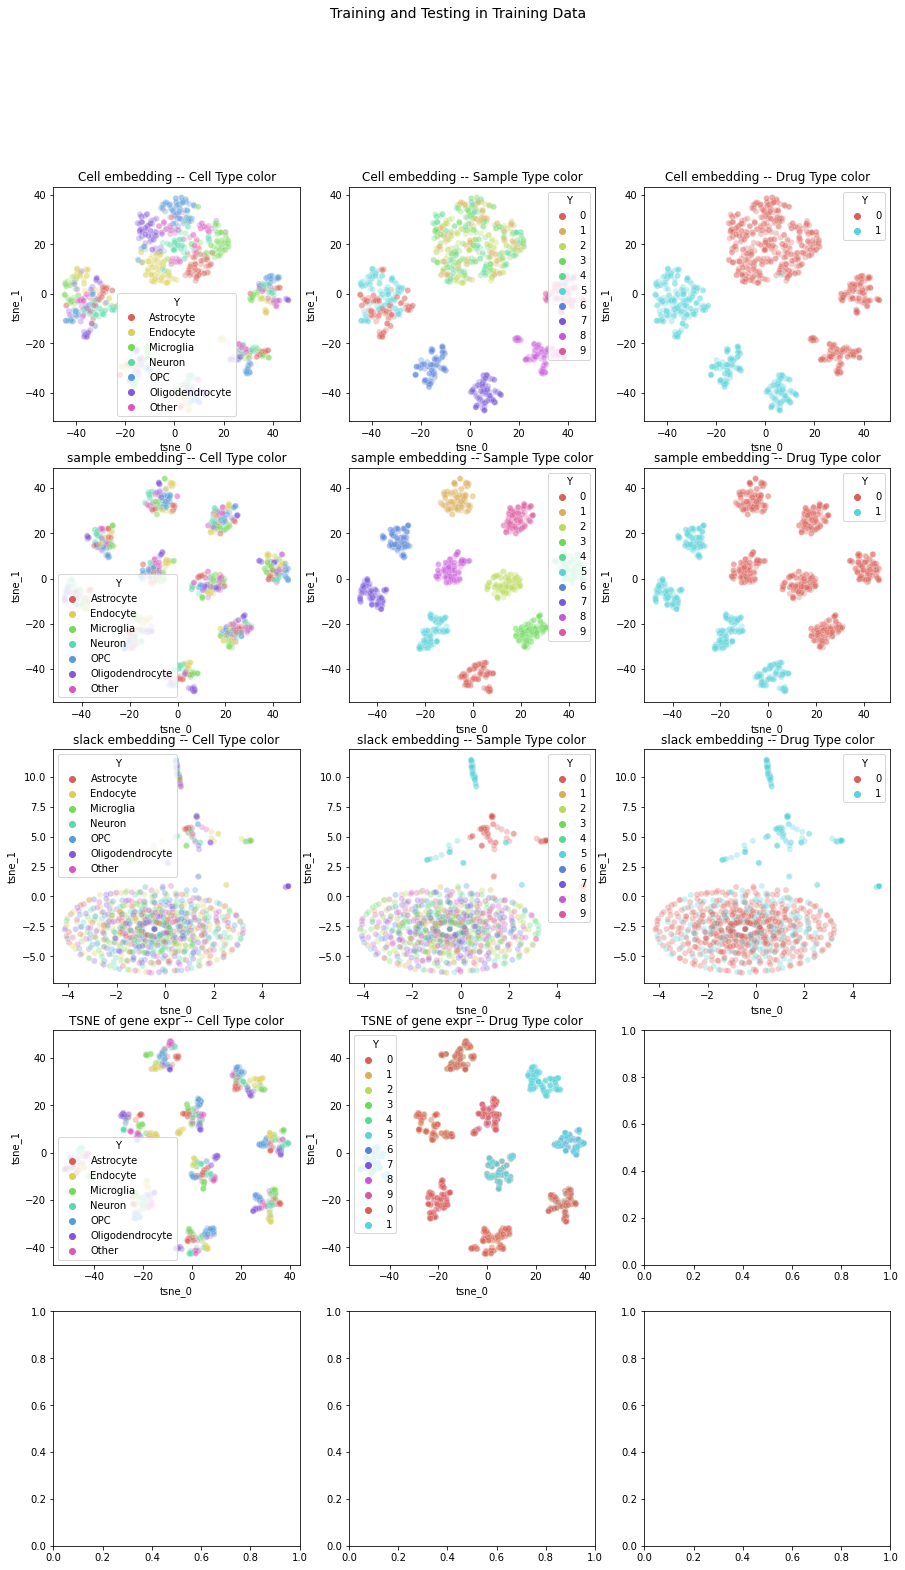

In [21]:
batch_size = 500

from numpy.random import randint

# plot proportions on labeled 10x and unlabeled 10x
# this is the training data
idx_train = np.where(np.logical_and(Label_full_10x!=5, Label_full_10x!=0))[0]
idx_unlab = np.where(Label_full_10x >= 5)[0]
idx_perturb = np.where(np.logical_and(Label_full_10x>5, Label_full_10x<8))[0]
idx_random = values = randint(0, 10000, 1000)

X_temp = cortex6k_X.reindex(columns=cortex6k_train, fill_value=0)
X_temp = X_temp.to_numpy()
X_temp = X_temp[idx_random]
X_temp = scale(X_temp, axis=1)

Y_temp = cortex6k_Y
Y_temp = cortex6k_Y.columns[np.argmax(Y_temp.to_numpy(), axis=1)]
Y_temp = Y_temp[idx_random]

label_temp = Label_full_10x[idx_random]
perturb_temp = Label_perturb[idx_random]

print(f"Number unique Y: {len(np.unique(Y_temp))}")

_, mu_slack, _, mu_prop, _, prop_outputs, _, mu_rot, _ = cortex6k_enc.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)

fig, axs = plt.subplots(5, 3, figsize=(15,25))

plot_df = get_tsne_for_plotting(np.asarray(mu_prop))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")
plot_tsne(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="Cell embedding -- Drug Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_rot))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")
plot_tsne(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="sample embedding -- Drug Type color")

# plot_df = get_tsne_for_plotting(np.asarray(mu_drug))
# plot_tsne(plot_df, color_vec=Y_temp, ax=axs[2,0], title="drug embedding -- Cell Type color")
# plot_tsne(plot_df, color_vec=label_temp, ax=axs[2,1], title="drug embedding -- Sample Type color")
# plot_tsne(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="drug embedding -- Drug Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_slack))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[2,0], title="slack embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[2,1], title="slack embedding -- Sample Type color")
plot_tsne(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="slack embedding -- Drug Type color")

plot_df = get_tsne_for_plotting(np.asarray(X_temp))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[3,0], title="TSNE of gene expr -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[3,1], title="TSNE of gene expr -- Sample Type color")
plot_tsne(plot_df, color_vec=perturb_temp, ax=axs[3,1], title="TSNE of gene expr -- Drug Type color")

fig.suptitle("Training and Testing in Training Data", fontsize=14)

fig.show()

In [22]:
for idx in range(0, 100, 10):
    print(idx)

0
10
20
30
40
50
60
70
80
90


In [23]:
_, mu_slack, _, mu_prop, _, prop_outputs, _, mu_rot, _  = cortex6k_enc.predict(X_temp, batch_size=batch_size)
z_test = prop_outputs
encodings= np.asarray(z_test)
encodings.shape

(1000, 7)

In [24]:
X_temp = cortex6k_X.reindex(columns=cortex6k_train, fill_value=0)
X_temp = X_temp.to_numpy()
Y_temp = cortex6k_Y
Y_temp = cortex6k_Y.columns[np.argmax(Y_temp.to_numpy(), axis=1)]
idx_b = np.where(Y_temp == 'Microglia')[0][0:1000]
X_temp = X_temp[idx_b]
X_temp = scale(X_temp, axis=1)
Y_temp = Y_temp[idx_b]

X_temp

array([[-3.06194214e-01, -3.00007158e-01, -3.09401013e-01, ...,
         1.04061297e+01,  7.46655436e+00,  3.39788313e+00],
       [-2.99603107e-01, -2.90149104e-01, -2.98807486e-01, ...,
        -2.14512165e-01,  1.19634329e+01,  2.14004264e-01],
       [-2.81044020e-01, -2.75799178e-01, -2.78095371e-01, ...,
         4.69198915e+00,  4.02100857e+01,  9.29612939e+00],
       ...,
       [-3.75729236e-01, -4.00971421e-01, -3.96426909e-01, ...,
         1.67303786e+00,  3.79922965e+00,  2.83328755e+00],
       [-3.38772223e-01, -3.53494292e-01, -3.53431794e-01, ...,
         1.31338333e+00,  1.95846111e+00,  5.69810553e+00],
       [-3.24088957e-01, -3.35702169e-01, -3.32665617e-01, ...,
         6.94266909e+00,  1.22506913e-01, -2.09547052e-02]])

Number unique Y: 7


/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.965768
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.603127
[t-SNE] KL divergence after 500 iterations: 0.895206
(2000, 2)
(2000, 2)
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...


/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 2000 samples in 0.100s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.380478
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.803932
[t-SNE] KL divergence after 500 iterations: 1.178331
(2000, 2)
(2000, 2)
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...


/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 2000 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 114.395287
[t-SNE] KL divergence after 500 iterations: 2.660453
(2000, 2)
(2000, 2)
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.008s...


/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 2000 samples in 0.233s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 7.350892
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.221512
[t-SNE] KL divergence after 500 iterations: 0.889714
(2000, 2)
(2000, 2)


Text(0.5, 0.98, 'Training Data -- perturbed + non perturbed')

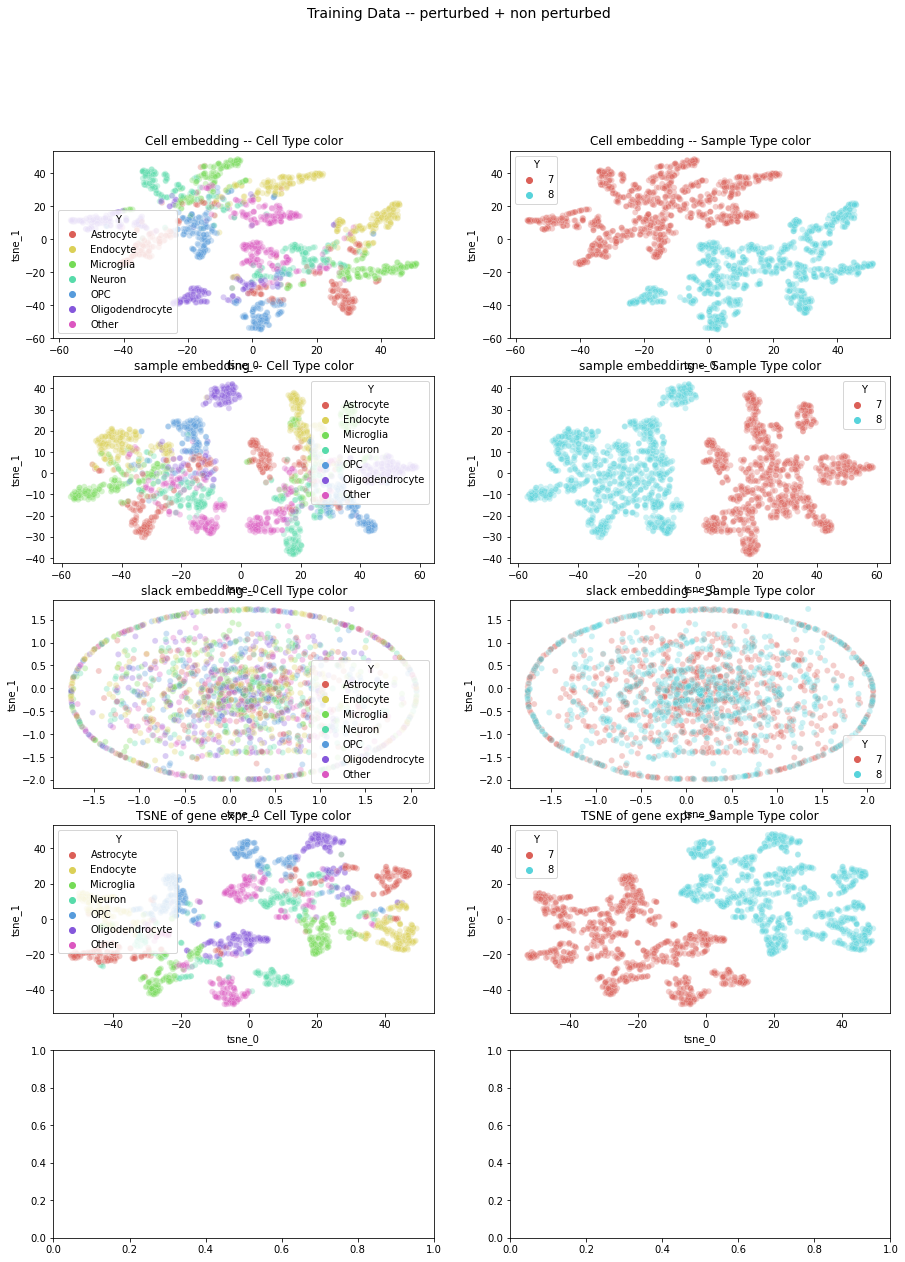

In [25]:
idx_perturb = np.where(np.logical_and(Label_full_10x>6, Label_full_10x<9))[0]

X_temp = cortex6k_X.reindex(columns=cortex6k_train, fill_value=0)
X_temp = X_temp.to_numpy()
X_temp = X_temp[idx_perturb]
X_temp = scale(X_temp, axis=1)

Y_temp = cortex6k_Y
Y_temp = cortex6k_Y.columns[np.argmax(Y_temp.to_numpy(), axis=1)]
Y_temp = Y_temp[idx_perturb]

label_temp = Label_full_10x[idx_perturb]


print(f"Number unique Y: {len(np.unique(Y_temp))}")

_, mu_slack, _, mu_prop, _, prop_outputs, _, mu_rot, _  = cortex6k_enc.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)


fig, axs = plt.subplots(5, 2, figsize=(15,20))

plot_df = get_tsne_for_plotting(np.asarray(mu_prop))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_rot))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")

# plot_df = get_tsne_for_plotting(np.asarray(mu_drug))
# plot_tsne(plot_df, color_vec=Y_temp, ax=axs[2,0], title="drug embedding -- Cell Type color")
# plot_tsne(plot_df, color_vec=label_temp, ax=axs[2,1], title="drug embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_slack))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[2,0], title="slack embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[2,1], title="slack embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(X_temp))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[3,0], title="TSNE of gene expr -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[3,1], title="TSNE of gene expr -- Sample Type color")


fig.suptitle("Training Data -- perturbed + non perturbed", fontsize=14)

/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/ivicha/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1460 samples in 0.004s...
[t-SNE] Computed neighbors for 1460 samples in 0.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1460
[t-SNE] Computed conditional probabilities for sample 1460 / 1460
[t-SNE] Mean sigma: 8.211987
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.258495
[t-SNE] KL divergence after 500 iterations: 0.569345
(1460, 2)
(1460, 2)


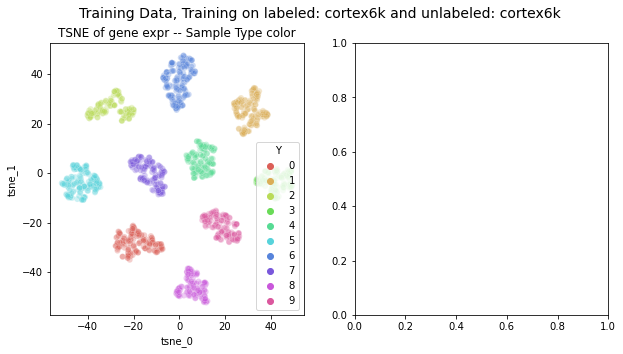

In [26]:
X_temp = cortex6k_X.reindex(columns=cortex6k_train, fill_value=0)
X_temp = X_temp.to_numpy()

Y_temp = cortex6k_Y
Y_temp = cortex6k_Y.columns[np.argmax(Y_temp.to_numpy(), axis=1)]

# select the b cells /// select the neurons?
idx_b = np.where(Y_temp == 'Neuron')[0]
X_temp = X_temp[idx_b]
X_temp = scale(X_temp, axis=1)
Y_temp = Y_temp[idx_b]
label_temp = Label_full_10x[idx_b]

fig, axs = plt.subplots(1, 2, figsize=(10,5))

plot_df = get_tsne_for_plotting(np.asarray(X_temp))
plot_tsne(plot_df, color_vec=label_temp, ax=axs[0], title="TSNE of gene expr -- Sample Type color")


fig.suptitle("Training Data, Training on labeled: cortex6k and unlabeled: cortex6k", fontsize=14)

fig.show()

Predict on our noise

Set-up Methods

In [27]:
def read_diva_result_file(res_path, train_id, test_id, unlab_id):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-unlab-{unlab_id}-DIVA.pkl")
    res_path = Path(res_file)
    res_df = pickle.load( open( res_path, "rb" ) )
    return res_df

def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df

def read_bp_init_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df


In [28]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


def get_errors_single(y_true, y_est):
  mse_err = [mean_sqr_error(y_true, y_est)]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true, y_est)[0]]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true, y_est)[0]]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"] + ["SPR"] + ["PEAR"]

  return plot_df
def plot_cell_specific_corr(xval, yval, ax, title, xlab, ylab):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax
    )
    g.set(ylim=(0, 1))
    g.set(xlim=(0, 1))
    g.plot([0, 1], [0, 1], transform=g.transAxes)

    ax.set_title(title)
    return g

First test only on re-sampled noise


We plot the Mean Squared Error (MSQ) and Pearson correlation with ground truth cell-type proportions. This is compared between BuDDI and BayesPrism (BP)

In [29]:
_, Y_test_df, test_gene_df, _ = sc_preprocess.read_diva_files(data_path, 6, "cortex6k", use_test=False)
Y_test_df

,Other,Neuron,Oligodendrocyte,Astrocyte,OPC,Microglia,Endocyte
0,0.0068,0.053,0.0002,0.0546,0.1426,0.7228,0.02
0,0.0,0.0,0.0,0.7406,0.0,0.255,0.0044
0,0.0614,0.0024,0.0408,0.0804,0.0078,0.5272,0.28
0,0.0796,0.411,0.0152,0.1032,0.1664,0.1476,0.077
0,0.0,0.0006,0.4698,0.0012,0.2884,0.008,0.232
...,...,...,...,...,...,...,...
0,0.0,0.111,0.0112,0.0194,0.0008,0.834,0.0236
0,0.0508,0.0052,0.6648,0.0084,0.1148,0.0496,0.1064
0,0.048,0.38,0.2584,0.0974,0.1046,0.0324,0.0792
0,0.0812,0.0178,0.5602,0.0288,0.2718,0.0234,0.0168


skipping because haven't run BayesPrism

In [37]:
#within_sample_test_bp  = read_bp_result_file(bp_res_path, "cortex6k", "cortex6k", num_samp=8100)
#within_sample_test_bp = within_sample_test_bp[5000:6000]
#within_sample_test_bp['mono'] = within_sample_test_bp['mono16'] + within_sample_test_bp['mono14']
#within_sample_test_bp

MSqE mean: 0.143580238783472, median: 0.1638546542400799, max: 0.28395606854645034
Spearman mean: 0.35051789497950947, median: 0.39285714285714296, max: 0.991031208965115
Pearson mean: 0.09607476462190655, median: -0.13714539668619866, max: 0.9999981734703383


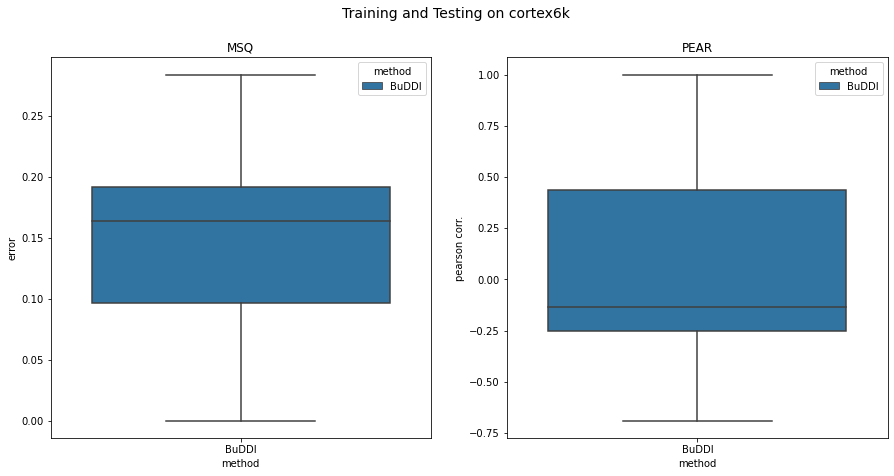

In [30]:
# first we test within the same sample
within_sample_test_diva  = read_diva_result_file(res_path, "cortex6k", "cortex6k", "cortex6k_200epoch_decLR")
within_sample_test_bp = within_sample_test_diva


#within_sample_test_bp  = read_bp_result_file(bp_res_path, "pbmc6k-mono", "pbmc6k-mono", num_samp=8100)
#within_sample_test_bp['mono'] = within_sample_test_bp['mono16'] + within_sample_test_bp['mono14']
within_sample_test_bp = within_sample_test_bp[5000:6000]
#within_sample_test_bp = pd.concat([within_sample_test_bp, within_sample_test_bp, 
#                                    within_sample_test_bp, within_sample_test_bp, 
#                                    within_sample_test_bp])
within_sample_test_bp = within_sample_test_bp.reindex(columns=within_sample_test_diva.columns, fill_value=0)

_, Y_test_df, test_gene_df, _ = sc_preprocess.read_diva_files(data_path, 6, "cortex6k", use_test=False)

#Y_test_df = pd.concat([Y_test_df, Y_test_df, Y_test_df, Y_test_df, Y_test_df])

Y_test_df = Y_test_df[within_sample_test_diva.columns]
Y_test = Y_test_df.to_numpy()

within_sample_test_bp = within_sample_test_bp[within_sample_test_diva.columns]

biorep_diva_err = get_errors(Y_test, within_sample_test_diva.to_numpy())
biorep_bp_err = biorep_diva_err
#biorep_bp_err = get_errors(Y_test, within_sample_test_bp.to_numpy())

biorep_diva_err["experiment"] = ["2_biorep"]*biorep_diva_err.shape[0]
biorep_diva_err["method"] = ["BuDDI"]*biorep_diva_err.shape[0]
biorep_bp_err["experiment"] = biorep_diva_err["experiment"]
biorep_bp_err["method"] = biorep_diva_err["method"]
#biorep_bp_err["experiment"] = ["2_biorep"]*biorep_bp_err.shape[0]
#biorep_bp_err["method"] = ["BuDDi_again"]*biorep_bp_err.shape[0]

plot_df = pd.concat([biorep_diva_err, biorep_bp_err])

fig, axs = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")
fig.suptitle("Training and Testing on cortex6k", fontsize=14)

fig.show()

MSqE mean: 0.04935603038306097, median: 0.04935603038306097, max: 0.04935603038306097
Spearman mean: 0.4133125092046703, median: 0.4133125092046703, max: 0.4133125092046703
Pearson mean: 0.4717047655477036, median: 0.4717047655477036, max: 0.4717047655477036


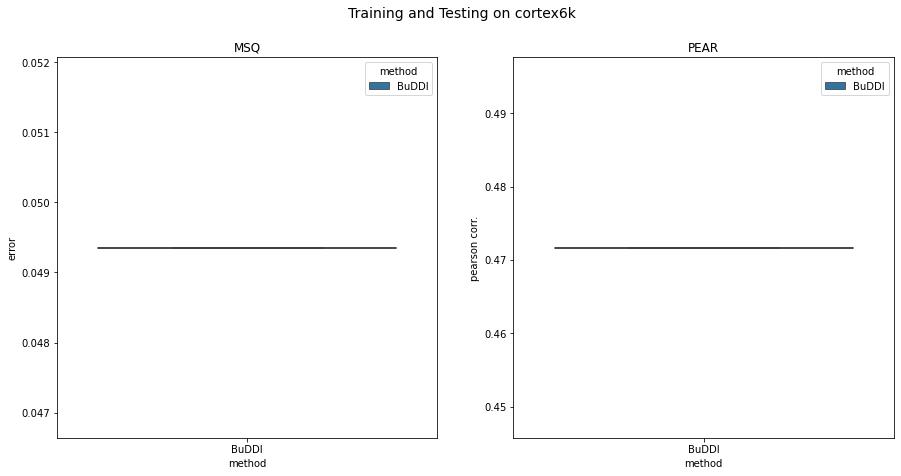

In [31]:
biorep_diva_err = get_errors_single(Y_test[:,2], within_sample_test_diva.to_numpy()[:,2])
biorep_bp_err = biorep_diva_err
#biorep_bp_err = get_errors_single(Y_test[:,2], within_sample_test_bp.to_numpy()[:,2])

biorep_diva_err["experiment"] = ["2_biorep"]*biorep_diva_err.shape[0]
biorep_diva_err["method"] = ["BuDDI"]*biorep_diva_err.shape[0]

biorep_bp_err["experiment"] = biorep_diva_err["experiment"]
biorep_bp_err["method"] = biorep_diva_err["method"]
#biorep_bp_err["experiment"] = ["2_biorep"]*biorep_bp_err.shape[0]
#biorep_bp_err["method"] = ["BP"]*biorep_bp_err.shape[0]

plot_df = pd.concat([biorep_diva_err, biorep_bp_err])

fig, axs = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")
fig.suptitle("Training and Testing on cortex6k", fontsize=14)

fig.show()

Now we plot the correlation across samples for a single cell type. This is compared between BuDDI and BayesPrism (BP)

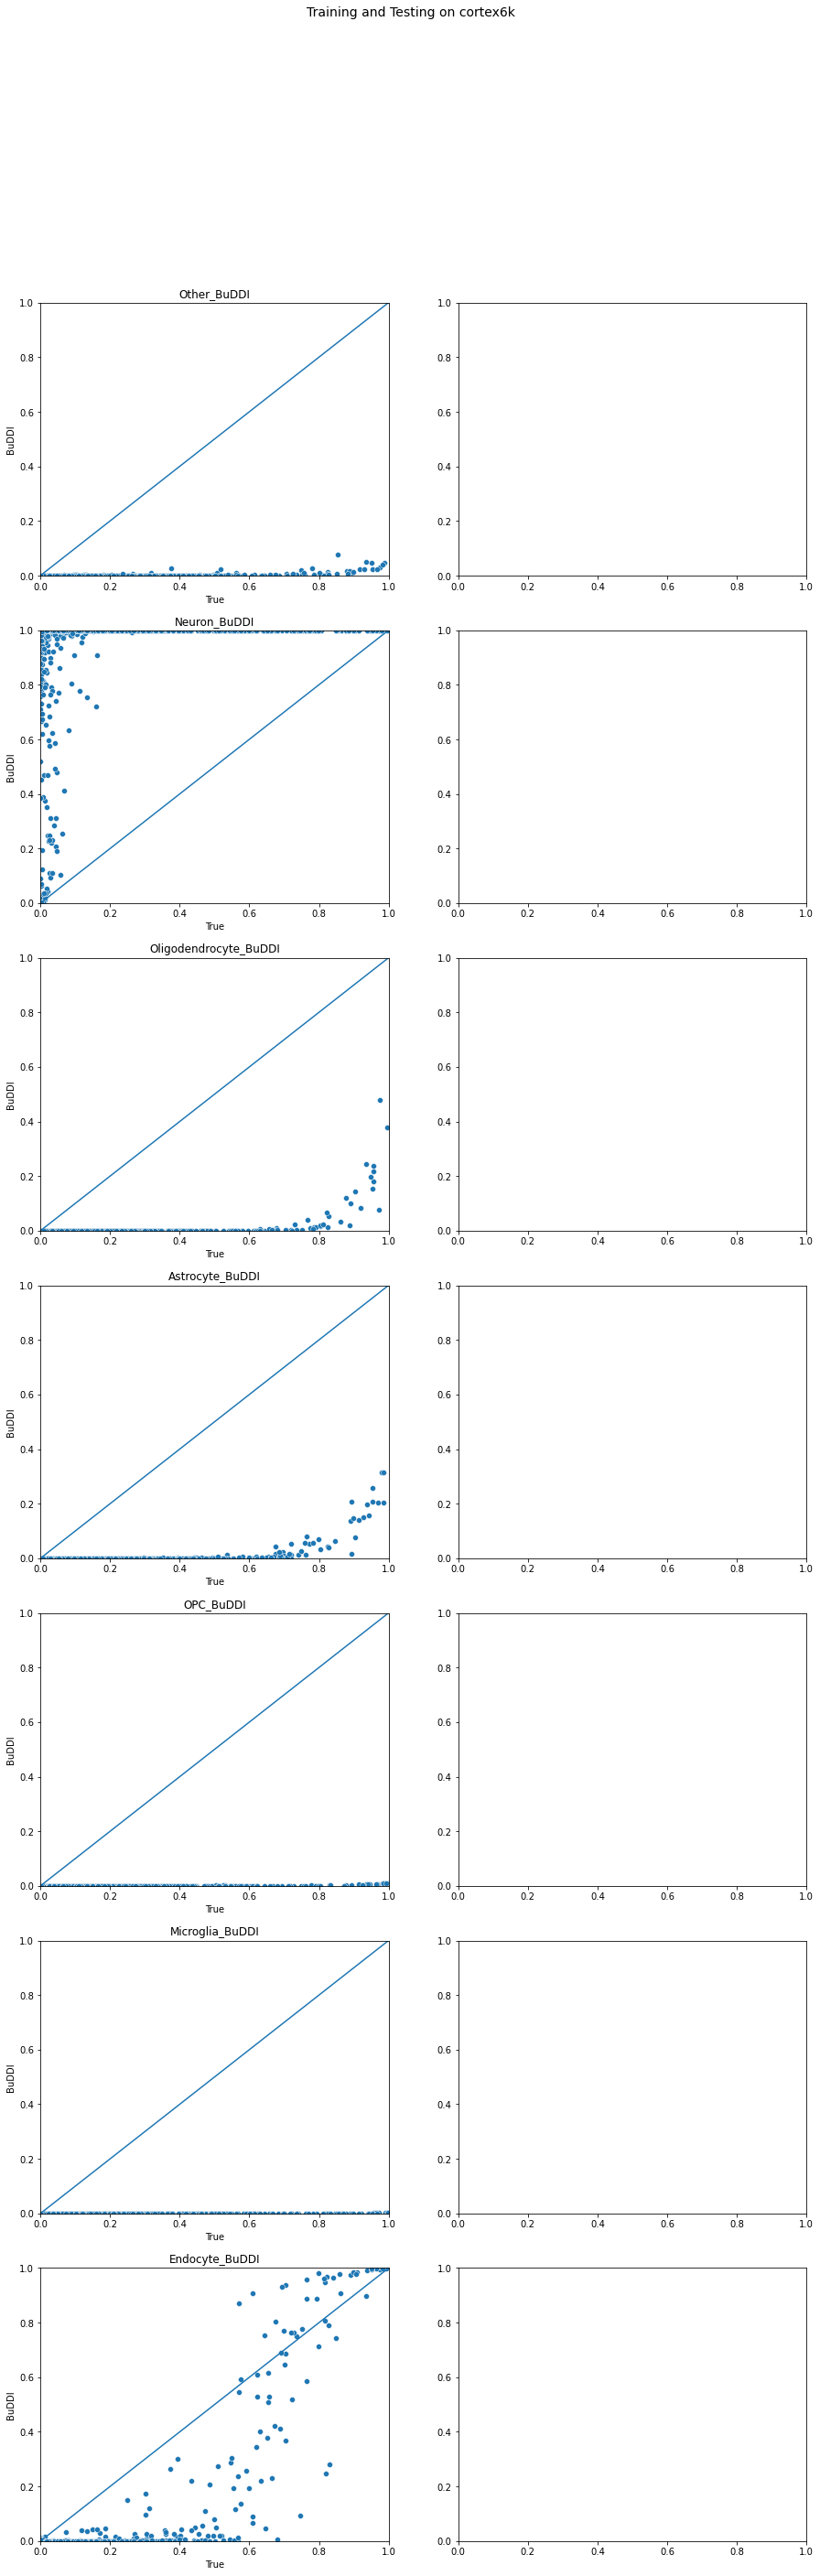

In [32]:
fig, axs = plt.subplots(7, 2, figsize=(15,45))
row_idx = 0
for curr_cell in Y_test_df.columns:

    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_diva[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI")
    #plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_bp[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BP", xlab="True", ylab="BP")
    row_idx = row_idx +1


fig.suptitle("Training and Testing on cortex6k", fontsize=14)

fig.show()

Now look at the reconstruction

MSqE mean: 0.15774471956543898, median: 0.17079434730679502, max: 0.285139922555476
Spearman mean: -0.001060217461888322, median: 0.0, max: 0.9642857142857145
Pearson mean: 0.010144825143851566, median: -0.1699512491099058, max: 0.9999999999924876


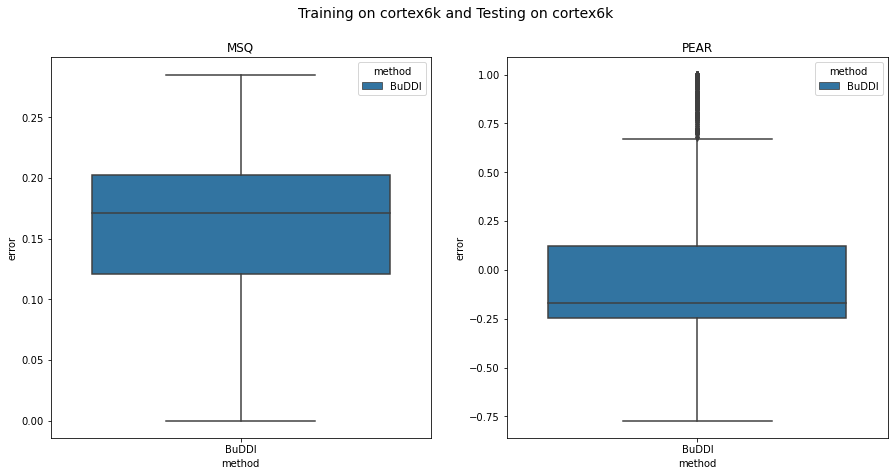

In [33]:
# first we test within the same sample
within_sample_test_diva  = read_diva_result_file(res_path, "cortex6k", "cortex6k", "cortex6k_200epoch_decLR")
#within_sample_test_bp  = read_bp_result_file(bp_res_path, "cortex6k_0", "pbmc3k_0", num_samp=100)
#within_sample_test_bp = within_sample_test_bp.reindex(columns=within_sample_test_diva.columns, fill_value=0)

_, Y_test_df, test_gene_df, _ = sc_preprocess.read_diva_files(data_path, 0, "cortex6k")

Y_test_df = Y_test_df[within_sample_test_diva.columns]
Y_test = Y_test_df.to_numpy()

biorep_diva_err = get_errors(Y_test, within_sample_test_diva.to_numpy())
#biorep_bp_err = get_errors(Y_test, within_sample_test_bp.to_numpy())
#biorep_diva_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_diva.to_numpy()))
#biorep_bp_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_bp.to_numpy()))

biorep_diva_err["experiment"] = ["2_biorep"]*biorep_diva_err.shape[0]
biorep_diva_err["method"] = ["BuDDI"]*biorep_diva_err.shape[0]

#biorep_bp_err["experiment"] = ["2_biorep"]*biorep_bp_err.shape[0]
#biorep_bp_err["method"] = ["BP"]*biorep_bp_err.shape[0]

plot_df = pd.concat([biorep_diva_err, biorep_bp_err])
#plot_df = biorep_diva_err

fig, axs = plt.subplots(1, 2, figsize=(15,7))

sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
fig.suptitle("Training on cortex6k and Testing on cortex6k", fontsize=14)

fig.show()

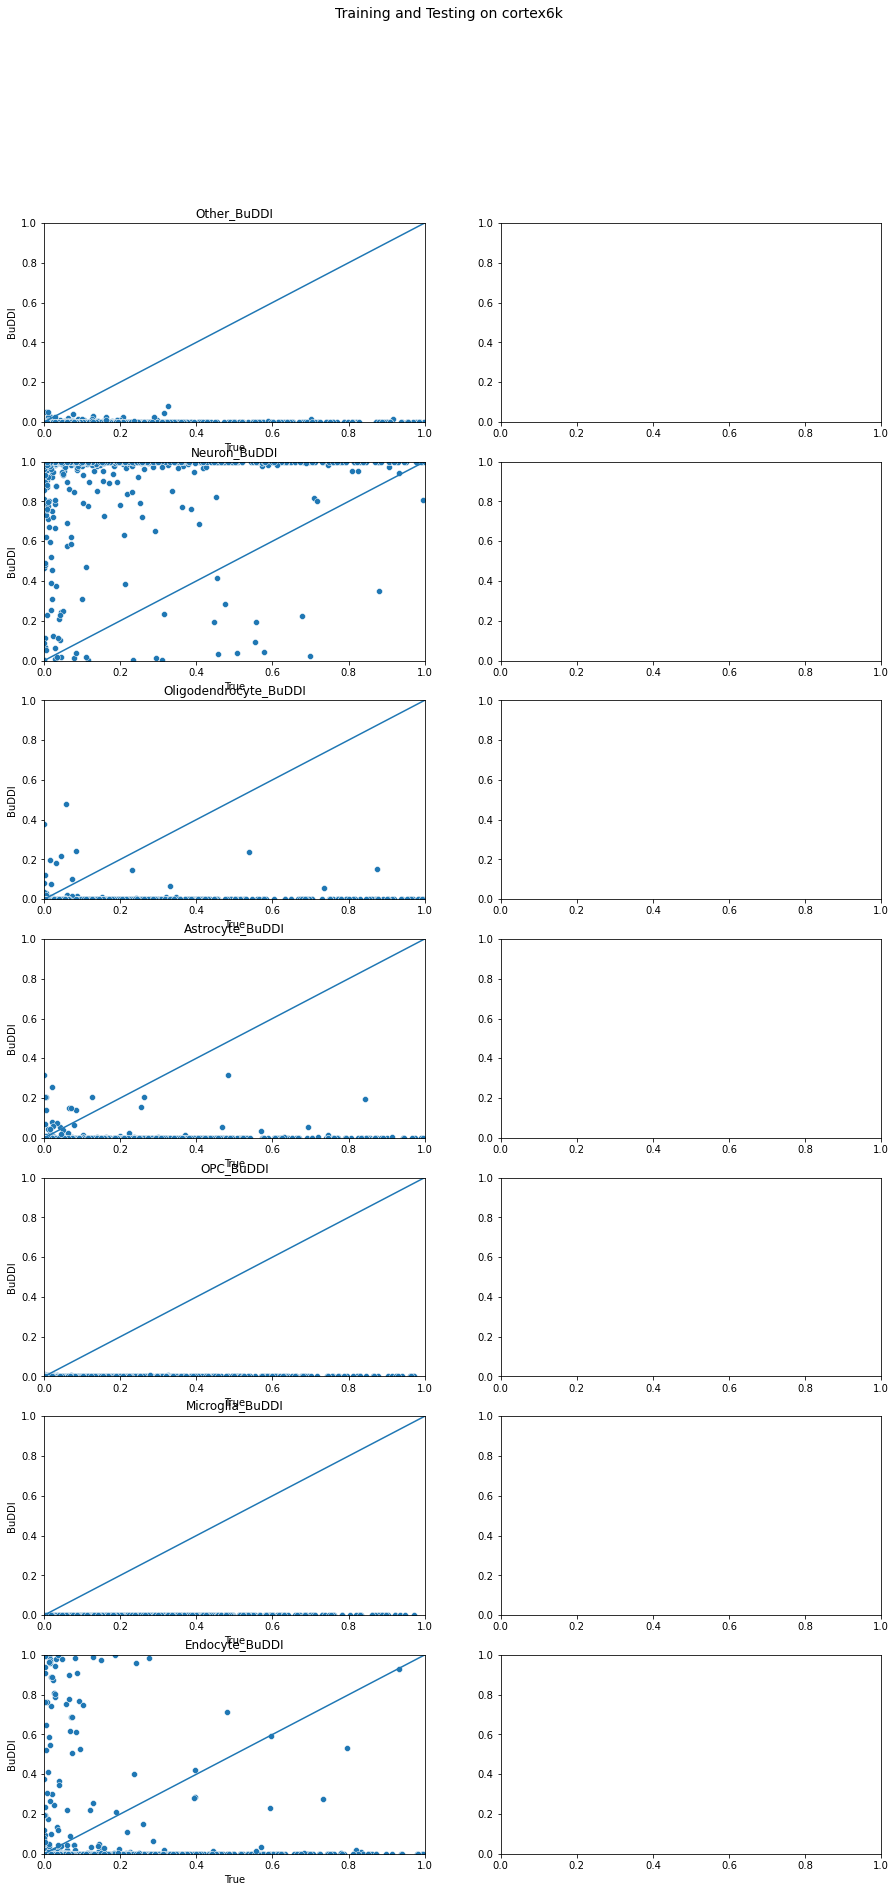

In [34]:
fig, axs = plt.subplots(7, 2, figsize=(15,30))
row_idx = 0
for curr_cell in Y_test_df.columns:

    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_diva[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI")
    #plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_bp[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BP", xlab="True", ylab="BP")
    row_idx = row_idx +1


fig.suptitle("Training and Testing on cortex6k", fontsize=14)

fig.show()